/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


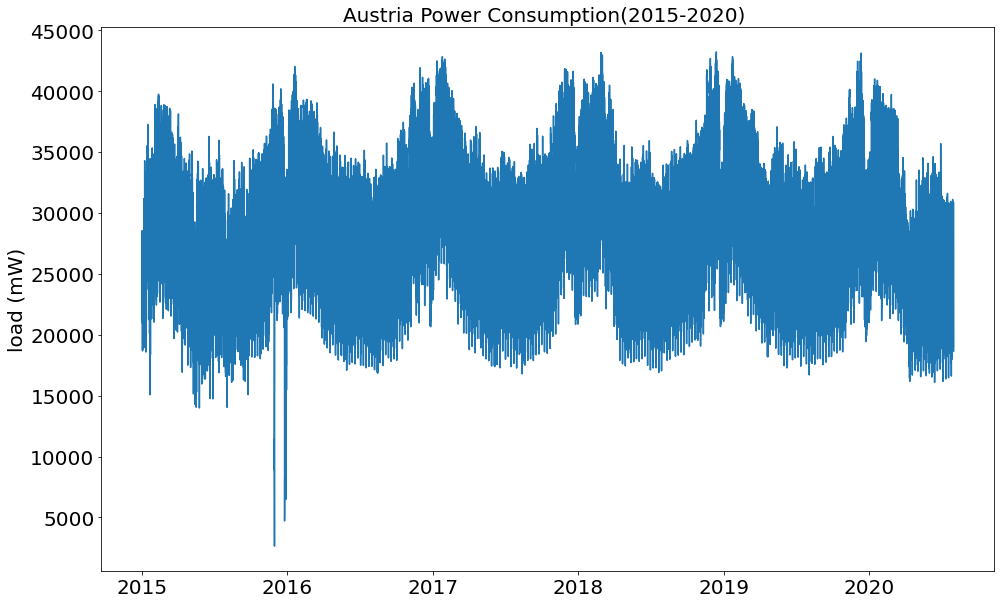

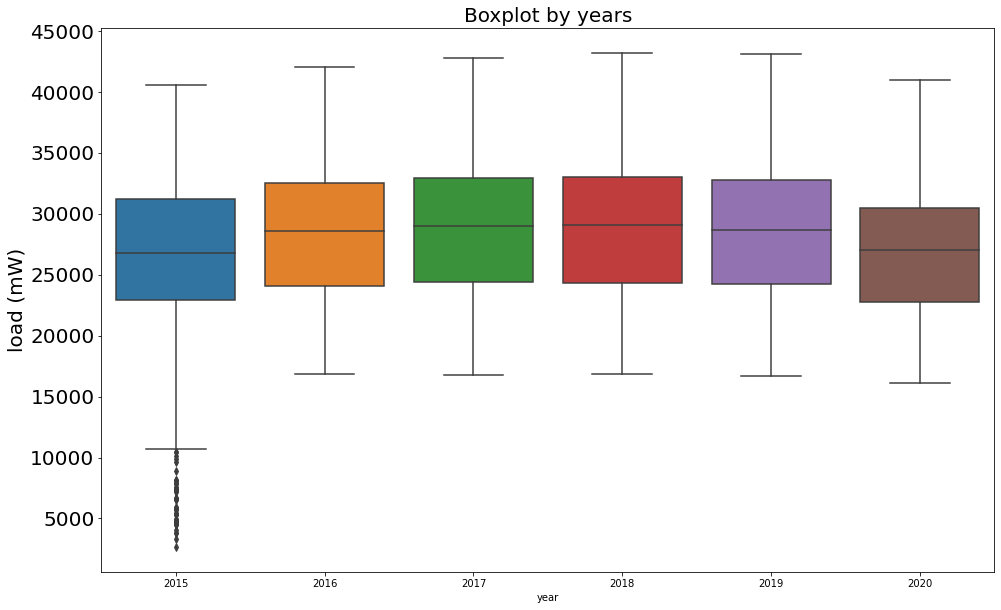

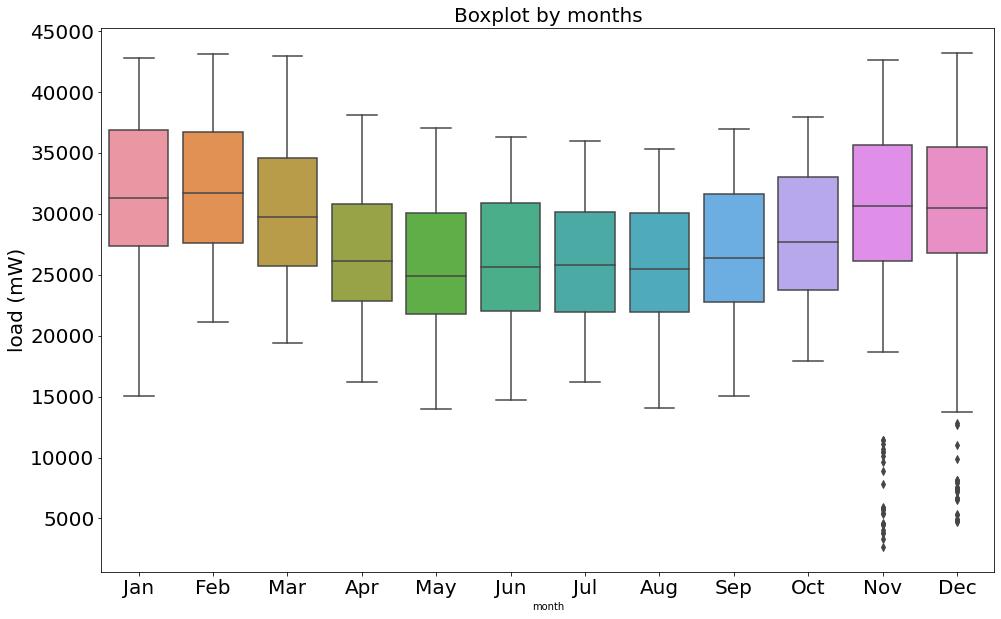

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 24, 120)           58560     
                                                                 
 lstm_16 (LSTM)              (None, 24, 80)            64320     
                                                                 
 lstm_17 (LSTM)              (None, 40)                19360     
                                                                 
 dense_23 (Dense)            (None, 1)                 41        
                                                                 
Total params: 142,281
Trainable params: 142,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1087/1087 [==============================] - 76s 64ms/step - loss: 0.0758 - val_loss: 0.0102
Epoch 2/2
1087/1087 [==============================] - 71s 65ms/step - loss: 

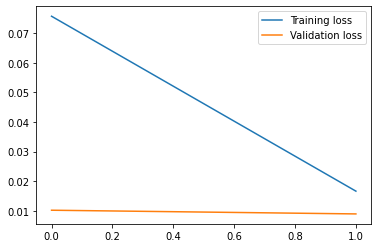

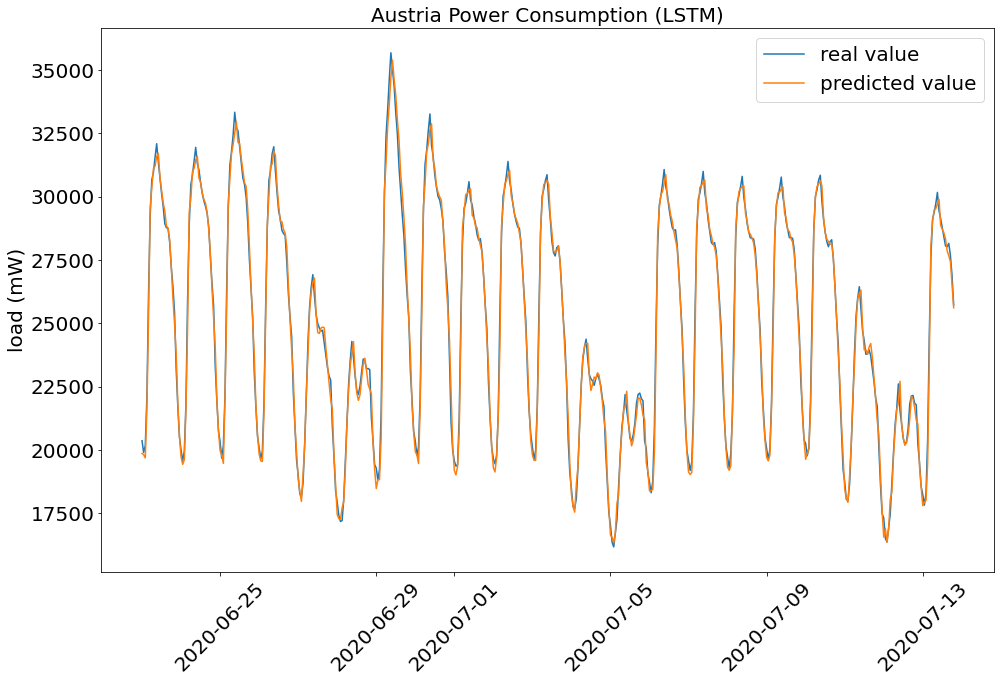

In [26]:
# LSTM modelling with standard input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

data = pd.read_csv(r'at.csv')
data_de = data.drop(['end'],axis=1)

train_set = data_de.loc[data_de['start'] <= '2019-05-31 00:00']
train_set = train_set.set_index("start")
train_set.index = pd.to_datetime(train_set.index)
train_set = train_set.groupby(pd.Grouper(freq="h")).sum()

test_set  = data_de.loc[data_de['start'] > '2019-05-31 00:00']
test_set = test_set.set_index("start")
test_set.index = pd.to_datetime(test_set.index)
test_set = test_set.groupby(pd.Grouper(freq="h")).sum()

data_de = data[['start', 'load']]
data_de['start'] = pd.to_datetime(data_de['start'])
data_de = data_de.set_index("start")
data_de = data_de.groupby(pd.Grouper(freq="h")).sum()

data_de['start'] = pd.to_datetime(data_de.index)

plt.figure(figsize=(16,10))
plt.plot(data_de['start'], data_de['load'])
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Austria Power Consumption(2015-2020) ',fontsize=20)

#%% Boxplots
"""[2]"""
df = data_de.set_index("start")
df.index = pd.to_datetime(df.index)

df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime("%b") for d in df.index]

plt.figure(figsize=(16,10))
sns.boxplot(x='year', y='load', data=df)
plt.ylabel("load (mW)", fontsize=20)
plt.yticks(fontsize=20)
plt.title('Boxplot by years',fontsize=20)
plt.show()

plt.figure(figsize=(16,10))
sns.boxplot(x='month', y='load', data=df)
plt.ylabel("load (mW)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Boxplot by months',fontsize=20)
plt.show()

#%%scaling, train_test_split
"""[3]"""
scaler=StandardScaler()
scaler = scaler.fit(train_set[['load']])

train_set['load'] = scaler.transform(train_set[['load']])
test_set['load'] = scaler.transform(test_set[['load']])

last_n = 24

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(x)-last_n):
        x_values.append(x.iloc[i:(i+last_n)].values)
        y_values.append(y.iloc[i+last_n])
    return np.array(x_values), np.array(y_values)

x_train, y_train = to_sequences(train_set[['load']], train_set['load'], last_n)
x_test, y_test = to_sequences(test_set[['load']], test_set['load'], last_n)

#%%LSTM Model
model=Sequential()
model.add(LSTM(120,return_sequences=True,input_shape=(last_n,1)))
model.add(LSTM(80,return_sequences=True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#%%Predictions (LSTM)
train_predict = model.predict(x_train)
test_predict  = model.predict(x_test)

predict_train = scaler.inverse_transform(train_predict)
predict_test  = scaler.inverse_transform(test_predict)

#%%Visualization of predictions(test_set)
previous_days = last_n

testPredictPlot = np.empty_like(df['load'])
testPredictPlot[:] = np.nan
testPredictPlot = testPredictPlot.reshape(-1,1)
testPredictPlot[len(train_predict)+(previous_days*2):len(df), :] = predict_test

df_tpp = pd.DataFrame(data=testPredictPlot, columns=['load'])
df_tpp['start'] = df.index
df_tpp['start'] = pd.to_datetime(df_tpp['start'])
df_tpp = df_tpp.set_index("start")

df_predict = df['load']

plt.figure(figsize=(16,10))
plt.plot(df_predict[48000:48500],label='real value')
plt.xticks(rotation=45)
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Austria Power Consumption (LSTM)',fontsize=20)
plt.plot(df_tpp[48000:48500],label='predicted value')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()



In [28]:
# Deep Autoencoder based compression
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 10  #encoding ratio=24/10

input_img = keras.Input(shape=(x_train.shape[1],))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
151/151 [==============================] - 3s 10ms/step - loss: -33690.3398 - val_loss: -441770.6562
Epoch 2/50
151/151 [==============================] - 1s 9ms/step - loss: -17573810.0000 - val_loss: -106860640.0000
Epoch 3/50
151/151 [==============================] - 1s 9ms/step - loss: -520969472.0000 - val_loss: -2002815360.0000
Epoch 4/50
151/151 [==============================] - 1s 8ms/step - loss: -4692595712.0000 - val_loss: -13859082240.0000
Epoch 5/50
151/151 [==============================] - 1s 8ms/step - loss: -23220344832.0000 - val_loss: -57991311360.0000
Epoch 6/50
151/151 [==============================] - 1s 8ms/step - loss: -80064184320.0000 - val_loss: -178870321152.0000
Epoch 7/50
151/151 [==============================] - 1s 9ms/step - loss: -217912180736.0000 - val_loss: -449669136384.0000
Epoch 8/50
151/151 [==============================] - 1s 8ms/step - loss: -501776678912.0000 - val_loss: -976400416768.0000
Epoch 9/50
151/151 [==================

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 120)           58560     
                                                                 
 lstm_19 (LSTM)              (None, 10, 80)            64320     
                                                                 
 lstm_20 (LSTM)              (None, 40)                19360     
                                                                 
 dense_36 (Dense)            (None, 1)                 41        
                                                                 
Total params: 142,281
Trainable params: 142,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1087/1087 [==============================] - 42s 30ms/step - loss: 0.7019 - val_loss: 0.6459
Epoch 2/2
1087/1087 [==============================] - 31s 28ms/step - loss: 

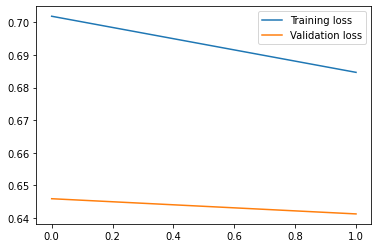

In [30]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
#%%LSTM Model over reduced dimensional input
encoded_data_train = encoder.predict(x_train)
encoded_data_test=encoder.predict(x_test)



model=Sequential()
model.add(LSTM(120,return_sequences=True,input_shape=(encoded_data_train.shape[1],1)))
model.add(LSTM(80,return_sequences=True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history = model.fit(encoded_data_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
